#Import Libraries

In [1]:
pip install statsmodels

In [2]:
import pandas as pd
import os
import numpy as np
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Load Data

Source: https://data.gov.sg/datasets?topics=housing&page=1&resultId=189

In [4]:
# List all files in the Colab directory
uploaded_files = os.listdir('/content/')
print("Files in Colab:", uploaded_files)

Files in Colab: ['.config', 'Resale flat prices based on registration date from Jan-2017 onwards.csv', 'Resale Flat Prices (Based on Approval Date), 1990 - 1999.csv', 'Resale Flat Prices (Based on Registration Date), From Jan 2015 to Dec 2016.csv', 'Resale Flat Prices (Based on Registration Date), From Mar 2012 to Dec 2014.csv', 'Resale Flat Prices (Based on Approval Date), 2000 - Feb 2012.csv', 'sample_data']


In [5]:
# Load each CSV file individually
file1 = pd.read_csv('/content/Resale Flat Prices (Based on Approval Date), 1990 - 1999.csv')
file2 = pd.read_csv('/content/Resale Flat Prices (Based on Approval Date), 2000 - Feb 2012.csv')
file3 = pd.read_csv('/content/Resale Flat Prices (Based on Registration Date), From Mar 2012 to Dec 2014.csv')
file4 = pd.read_csv('/content/Resale Flat Prices (Based on Registration Date), From Jan 2015 to Dec 2016.csv')
file5 = pd.read_csv('/content/Resale flat prices based on registration date from Jan-2017 onwards.csv')


In [6]:
# Print column names of each CSV
print("Columns in file1:", file1.columns)
print("Columns in file2:", file2.columns)
print("Columns in file3:", file3.columns)
print("Columns in file4:", file4.columns)
print("Columns in file5:", file5.columns)

Columns in file1: Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object')
Columns in file2: Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object')
Columns in file3: Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object')
Columns in file4: Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price'],
      dtype='object')
Columns in file5: Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale

file4 and file5 contain an extra column "remaining_lease"

In [7]:
# Add missing 'remaining_lease' column to file1, file2, and file3
for df in [file1, file2, file3]:
    df['remaining_lease'] = np.nan  # Assign NaN to missing column

In [8]:
# Concatenate all files
df = pd.concat([file1, file2, file3, file4, file5], ignore_index=True)

# Display dataset info to confirm
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945530 entries, 0 to 945529
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                945530 non-null  object 
 1   town                 945530 non-null  object 
 2   flat_type            945530 non-null  object 
 3   block                945530 non-null  object 
 4   street_name          945530 non-null  object 
 5   storey_range         945530 non-null  object 
 6   floor_area_sqm       945530 non-null  float64
 7   flat_model           945530 non-null  object 
 8   lease_commence_date  945530 non-null  int64  
 9   resale_price         945530 non-null  float64
 10  remaining_lease      236480 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 79.4+ MB
None


In [9]:
# Check data
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,NaN
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,NaN
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,NaN
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,NaN
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,NaN


In [10]:
# Process remaining_lease
df['remaining_lease'] = df['remaining_lease'].astype(str).str.extract('(\d+)').astype(float)

#Feature Engineering



## Time-Based Features
Convert transaction dates into year, month and quarter for trend detection



In [11]:
# Convert month to datetime format
df['month'] = pd.to_datetime(df['month'])

# Extract year, month, and quarter
df['year'] = df['month'].dt.year
df['month_num'] = df['month'].dt.month
df['quarter'] = df['month'].dt.quarter
df['year_month'] = df['month'].dt.to_period('M').astype(str)

# Drop the original month column (since we now have extracted features)
df.drop(columns=['month'], inplace=True)

print("✅ Time-based features added!")
display(df[['year', 'month_num', 'quarter', 'year_month']])


✅ Time-based features added!


,year,month_num,quarter,year_month
0,1990,1,1,1990-01
1,1990,1,1,1990-01
2,1990,1,1,1990-01
3,1990,1,1,1990-01
4,1990,1,1,1990-01
...,...,...,...,...
945525,2025,1,1,2025-01
945526,2025,1,1,2025-01
945527,2025,1,1,2025-01
945528,2025,1,1,2025-01


In [12]:
df[['year', 'month_num', 'quarter', 'year_month']].sample(20)  # Show 20 random rows

,year,month_num,quarter,year_month
496019,2006,6,2,2006-06
690029,2013,10,4,2013-10
674721,2012,11,4,2012-11
106686,1995,11,4,1995-11
640814,2011,5,2,2011-05
345210,2001,8,3,2001-08
461287,2005,3,1,2005-03
63609,1994,3,1,1994-03
855775,2021,10,4,2021-10
216955,1998,10,4,1998-10


##Location-Based Features
Encode town, street name using Label Encoding

In [13]:
print("Number of unique streets:", df['street_name'].nunique())
print("Top 10 most common streets:\n", df['street_name'].value_counts().head(10))

Number of unique streets: 589
Top 10 most common streets:
 street_name
YISHUN RING RD        17847
BEDOK RESERVOIR RD    14900
ANG MO KIO AVE 10     13986
ANG MO KIO AVE 3      12294
HOUGANG AVE 8          9467
TAMPINES ST 21         8379
BEDOK NTH ST 3         7649
BEDOK NTH RD           7556
ANG MO KIO AVE 4       7318
MARSILING DR           6739
Name: count, dtype: int64


Machine learning requires numerical data instead of text hence we use Label Encoding to replace each unique category with an integer

In [14]:
# Label Encoding for town and street_name
le_town = LabelEncoder()
le_street = LabelEncoder()

df['town'] = le_town.fit_transform(df['town'])
df['street_name'] = le_street.fit_transform(df['street_name'])

# Save mappings for later use
town_mapping = dict(zip(le_town.classes_, le_town.transform(le_town.classes_)))
street_mapping = dict(zip(le_street.classes_, le_street.transform(le_street.classes_)))

In [15]:
# Show full columns for town and street_name
display(df[['town', 'street_name']])


,town,street_name
0,0,14
1,0,14
2,0,14
3,0,14
4,0,14
...,...,...
945525,26,558
945526,26,568
945527,26,568
945528,26,577


In [16]:
df[['town', 'street_name']].sample(20)  # Show 20 random rows


,town,street_name
367382,11,208
151893,3,84
868722,20,516
61640,9,155
529817,0,14
289233,24,257
794516,25,546
619357,11,215
551720,25,539
902059,14,519


##Flat Characteristics
Include floor area, flat type, storey range as numerical inputs

In [17]:
# Label Encoding for categorical flat details
le_flat_type = LabelEncoder()
le_storey_range = LabelEncoder()
le_flat_model = LabelEncoder()

df['flat_type'] = le_flat_type.fit_transform(df['flat_type'])
df['storey_range'] = le_storey_range.fit_transform(df['storey_range'])
df['flat_model'] = le_flat_model.fit_transform(df['flat_model'])

In [18]:
# Drop unused columns
df.drop(columns=['block'], inplace=True)

In [19]:
# Check final dataset structure
print("✅ Flat characteristic features processed!")
display(df[['flat_type', 'storey_range', 'flat_model', 'floor_area_sqm']])

✅ Flat characteristic features processed!


,flat_type,storey_range,flat_model,floor_area_sqm
0,0,5,7,31.0
1,0,2,7,31.0
2,0,5,7,31.0
3,0,4,7,31.0
4,2,2,20,73.0
...,...,...,...,...
945525,5,0,15,145.0
945526,5,2,15,146.0
945527,5,4,5,142.0
945528,5,2,15,146.0


# XGBoost Model

Train a regression model to predict resale prices.

## XGBoost Training

In [20]:
# Feature-target split
X = df.drop(columns=['resale_price'])
y = df['resale_price']

In [21]:
# Train-test split (same for all)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# For LSTM and ARIMA, get monthly averages
monthly_avg = df.groupby('year_month')['resale_price'].mean().reset_index()
monthly_avg['year_month'] = pd.to_datetime(monthly_avg['year_month'])

# Time series format
monthly_avg.set_index('year_month', inplace=True)
monthly_avg = monthly_avg.asfreq('MS')

In [23]:
# Train-test split
train_size = int(len(monthly_avg) * 0.8)
train = monthly_avg.iloc[:train_size]
test = monthly_avg.iloc[train_size:]

In [24]:
# Find best (p,d,q) order using training data
"""auto_model = auto_arima(train,
                      seasonal=False,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print("Best ARIMA order:", auto_model.order)

# Summary of best model
print(auto_model.summary())
model = ARIMA(train, order=auto_model.order)"""

'auto_model = auto_arima(train,\n                      seasonal=False,\n                      trace=True,\n                      error_action=\'ignore\',\n                      suppress_warnings=True,\n                      stepwise=True)\n\nprint("Best ARIMA order:", auto_model.order)\n\n# Summary of best model\nprint(auto_model.summary())\nmodel = ARIMA(train, order=auto_model.order)'

In [25]:
# ARIMA
model = ARIMA(train, order=(1, 1, 2))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

In [26]:
print(forecast.head(10))
print(test.head(10))


2018-01-01    449358.849339
2018-02-01    449931.927039
2018-03-01    450442.427312
2018-04-01    450897.183324
2018-05-01    451302.282088
2018-06-01    451663.145947
2018-07-01    451984.605146
2018-08-01    452270.962491
2018-09-01    452526.050943
2018-10-01    452753.284919
Freq: MS, Name: predicted_mean, dtype: float64
             resale_price
year_month               
2018-01-01  446379.566231
2018-02-01  443147.783601
2018-03-01  457069.770335
2018-04-01  448189.233950
2018-05-01  448849.018966
2018-06-01  442732.183291
2018-07-01  444896.944072
2018-08-01  441601.175075
2018-09-01  433734.422484
2018-10-01  430989.157631


## Evaluate Model

In [35]:
# Calculate MAE
mae = mean_absolute_error(test, forecast)
print(f"📉 Mean Absolute Error (MAE): {mae:.2f}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"📉 Root Mean Squared Error (RMSE): {rmse:.2f}")

# Calculate MAPE
mape = np.mean(np.abs((test.values - forecast.values) / test.values)) * 100
print(f"📉 Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

📉 Mean Absolute Error (MAE): 69533.19
📉 Root Mean Squared Error (RMSE): 88586.09
📉 Mean Absolute Percentage Error (MAPE): 12.59%


MAE Value = Model's predictions are off by $Value

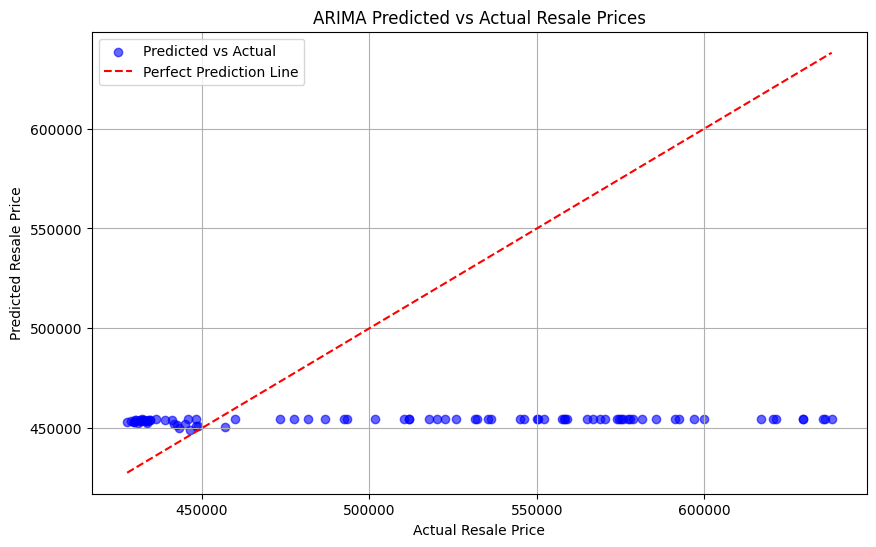

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(test.values, forecast, color='blue', alpha=0.6, label='Predicted vs Actual')
plt.plot([min(test.values), max(test.values)],
         [min(test.values), max(test.values)],
         color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel("Actual Resale Price")
plt.ylabel("Predicted Resale Price")
plt.title("ARIMA Predicted vs Actual Resale Prices")
plt.legend()
plt.grid()
plt.show()

# Visualize Market Trends

##Monthly Trends

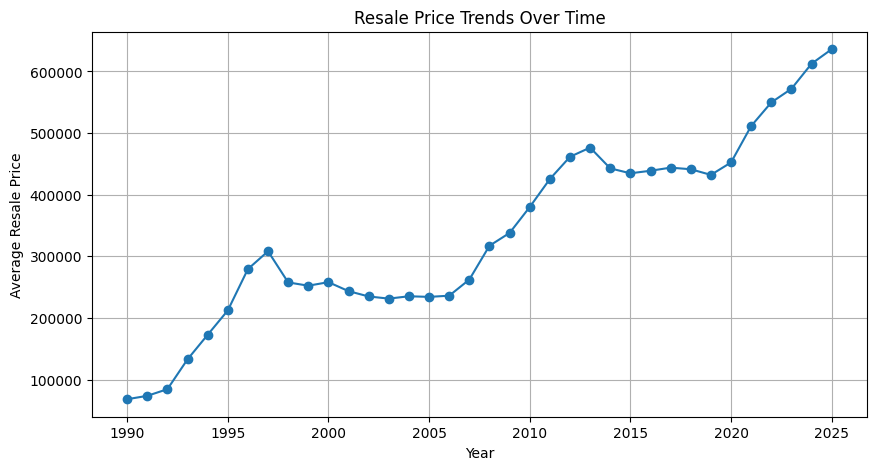

In [29]:
# Group data by year and calculate average resale price
yearly_trends = df.groupby('year')['resale_price'].mean()

plt.figure(figsize=(10, 5))
plt.plot(yearly_trends.index, yearly_trends.values, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Average Resale Price')
plt.title('Resale Price Trends Over Time')
plt.grid()
plt.show()


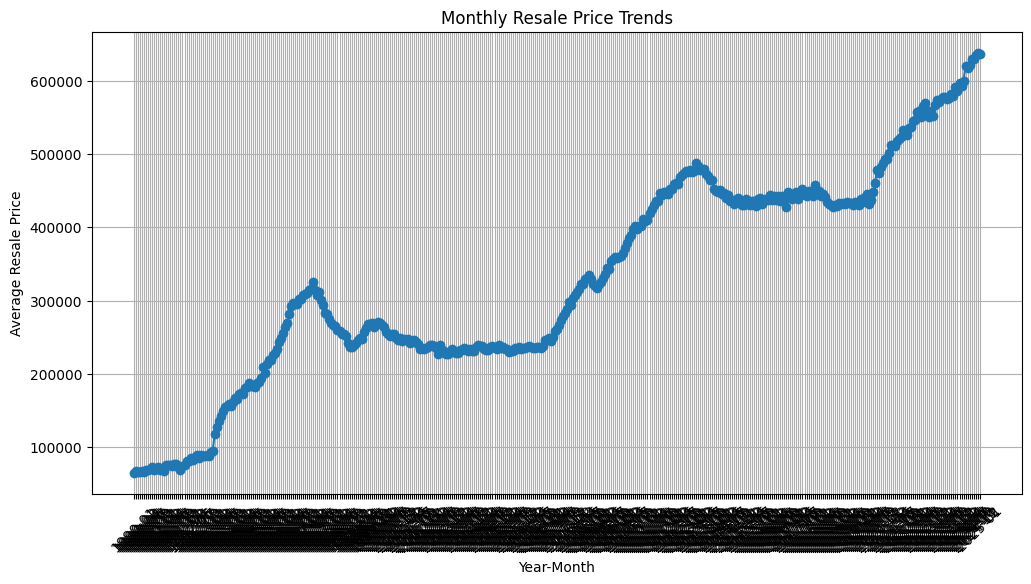

In [30]:
# Create a new column for year-month
df['year_month'] = df['year'].astype(str) + "-" + df['month_num'].astype(str).str.zfill(2)

# Group by year-month and get the average resale price
monthly_trends = df.groupby('year_month')['resale_price'].mean()

# Plot monthly trends
plt.figure(figsize=(12, 6))
plt.plot(monthly_trends.index, monthly_trends.values, marker='o', linestyle='-')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.xlabel('Year-Month')
plt.ylabel('Average Resale Price')
plt.title('Monthly Resale Price Trends')
plt.grid()
plt.show()


## Location-Based Analysis

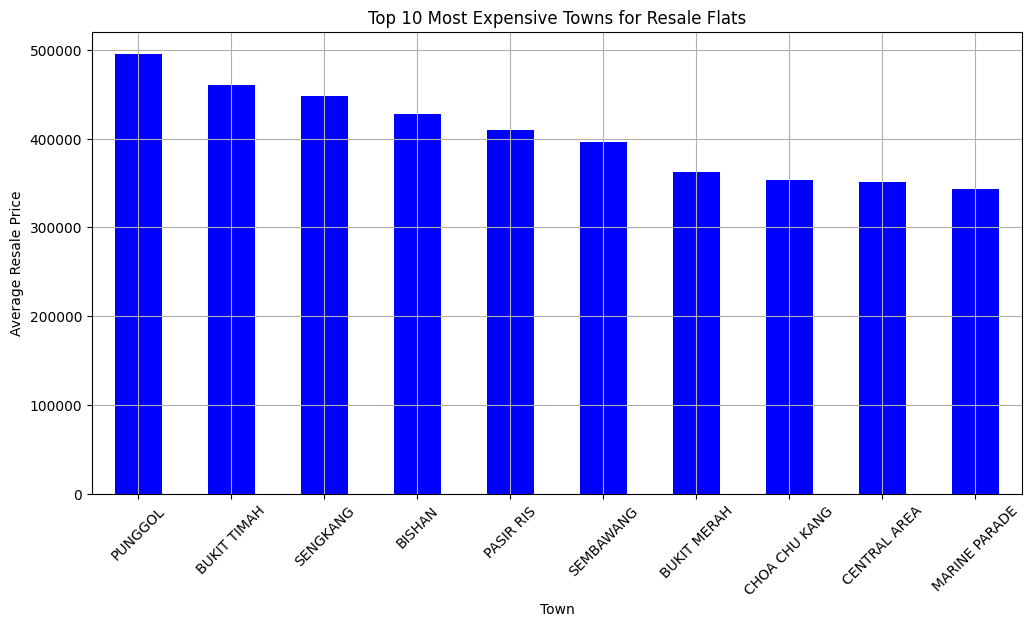

In [31]:
# Group data by town and calculate average resale price
town_trends = df.groupby('town')['resale_price'].mean().sort_values(ascending=False).head(10)

# Convert town numbers back to names
town_trends.index = town_trends.index.map(lambda x: le_town.inverse_transform([x])[0])

# Plot the corrected town names
plt.figure(figsize=(12, 6))
town_trends.plot(kind='bar', color='blue')
plt.xlabel("Town")
plt.ylabel("Average Resale Price")
plt.title("Top 10 Most Expensive Towns for Resale Flats")
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [32]:
# Create a 'decade' column
df['decade'] = (df['year'] // 10) * 10  # This converts 1995 → 1990, 2007 → 2000, etc.

# Check if it worked
df[['year', 'decade']].sample(10)

,year,decade
342019,2001,2000
641586,2011,2010
390394,2002,2000
695528,2014,2010
221500,1998,1990
467888,2005,2000
85884,1995,1990
585877,2009,2000
943919,2025,2020
832056,2020,2020


In [33]:
# Group by decade and town, then calculate the average resale price
decade_town_prices = df.groupby(['decade', 'town'])['resale_price'].mean().reset_index()

# Find the top 5 most expensive towns for each decade
top_towns_per_decade = decade_town_prices.sort_values(['decade', 'resale_price'], ascending=[True, False])

# Show only the top 5 towns per decade
top_towns_per_decade = top_towns_per_decade.groupby('decade').head(5)

# Convert town labels back to names
top_towns_per_decade['town'] = top_towns_per_decade['town'].map(lambda x: le_town.inverse_transform([x])[0])

# Round resale_price to whole numbers
top_towns_per_decade['resale_price'] = top_towns_per_decade['resale_price'].round(0).astype(int)

print(top_towns_per_decade)

    decade           town  resale_price
17    1990      PASIR RIS        373272
2     1990         BISHAN        344194
6     1990    BUKIT TIMAH        339514
8     1990  CHOA CHU KANG        302621
22    1990       TAMPINES        263429
32    2000    BUKIT TIMAH        360896
43    2000        PUNGGOL        348294
28    2000         BISHAN        340377
42    2000      PASIR RIS        336040
41    2000  MARINE PARADE        311503
58    2010    BUKIT TIMAH        655256
54    2010         BISHAN        581855
59    2010   CENTRAL AREA        554415
56    2010    BUKIT MERAH        532322
67    2010  MARINE PARADE        520753
84    2020    BUKIT TIMAH        778317
80    2020         BISHAN        719041
85    2020   CENTRAL AREA        700530
96    2020     QUEENSTOWN        652193
82    2020    BUKIT MERAH        651195


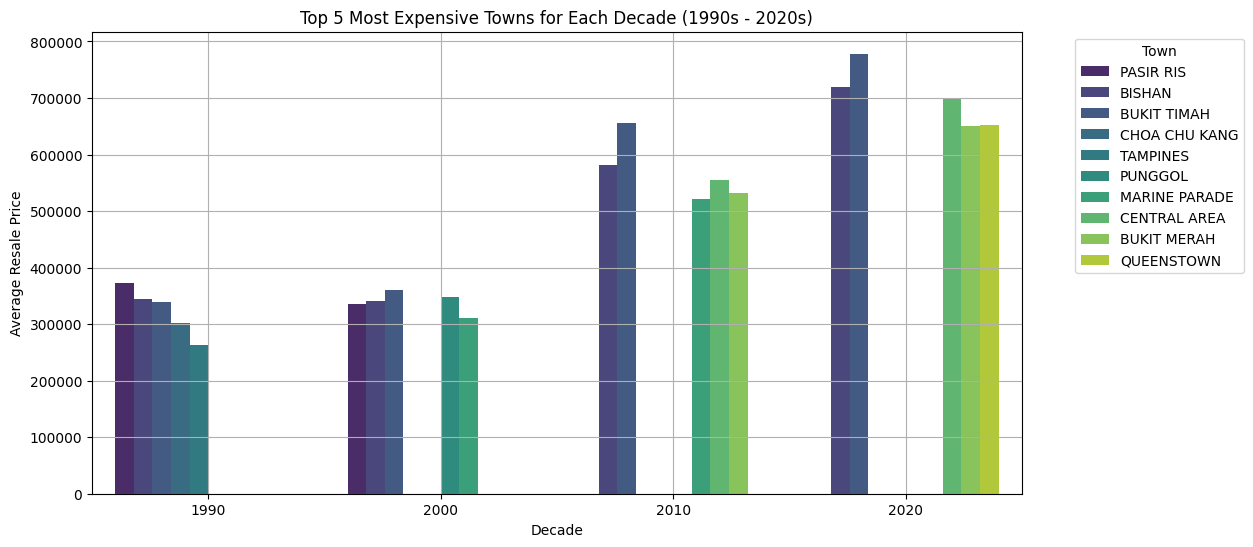

In [34]:
plt.figure(figsize=(12, 6))

sns.barplot(
    data=top_towns_per_decade,
    x='decade',
    y='resale_price',
    hue='town',
    palette='viridis'
)

plt.xlabel("Decade")
plt.ylabel("Average Resale Price")
plt.title("Top 5 Most Expensive Towns for Each Decade (1990s - 2020s)")
plt.legend(title="Town", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()